### INFO284 Machine Learning Exam, spring 2024

#### Importing and versioncontrol for relevant libraries

In [25]:
import sys
print("Python version: {}".format(sys.version))
import pandas as pd
print("pandas version: {}".format(pd.__version__))
import matplotlib
import matplotlib.pyplot as plt
print("matplotlib version: {}".format(matplotlib.__version__))
import numpy as np
print("NumPy version: {}".format(np.__version__))
import scipy as sp
print("SciPy version: {}".format(sp.__version__))
import IPython
print("IPython version: {}".format(IPython.__version__))
import sklearn
print("scikit-learn version: {}".format(sklearn.__version__))
import seaborn as sns
print("seaborn version: {}".format(sns.__version__))

Python version: 3.12.2 (tags/v3.12.2:6abddd9, Feb  6 2024, 21:26:36) [MSC v.1937 64 bit (AMD64)]
pandas version: 2.2.1
matplotlib version: 3.8.3
NumPy version: 1.26.4
SciPy version: 1.12.0
IPython version: 8.21.0
scikit-learn version: 1.4.1.post1
seaborn version: 0.13.2


#### Importing the dataset

In [26]:
filePath = 'elektronisk-rapportering-ers-2018-fangstmelding-dca-simple.csv'
# Keep in mind that the file is encoded in UTF-8 so it will only work if you have the correct version of pandas.
df = pd.read_csv(filePath, encoding="UTF-8" , delimiter=";")
print(f"Before pre-processing the dataset has {df.shape[1]} columns and {df.shape[0]} rows")


Before pre-processing the dataset has 45 columns and 305434 rows


#### Chosing target and pre-prossesing
After taking some time to understand the data we have chosen our target features to be the catches of Hyse, Torsk and Sei as continuous values. Next we will pre-prosess the data so it is ready for modeling.

In [27]:
# Using the same seed for testing purposes makes the results more comparable
seed = 32

In [28]:
# Excluding irrelevant columns

# Fangstår has only 2 unique values
df.drop(columns = ['Fangstår'], inplace= True)

# Lengdegruppe (kode), Lengdegruppe, Bruttotonnasje 1969, Bruttotonnasje annen, Bredde, Fartøylengde all seem to be speaking of the boat doing the catching, with few unique values in each column.
# One of them should be kept as a feature, the rest discarded. We would suggest the most relevant to be Bruttotonasje, which speaks to how much cargo space there is.
# "Bruttotonnasje 1969" and "Bruttotonnasje annen" seem to have nan where the other one has a value, so first we will collapse them into one.
df['Bruttotonnasje'] = df['Bruttotonnasje annen'].combine_first(df['Bruttotonnasje 1969'])
df.drop(columns=['Bruttotonnasje annen', "Bruttotonnasje 1969","Lengdegruppe (kode)", "Lengdegruppe", "Bredde", "Fartøylengde"], inplace=True)

# All columns (kode) in them are cateogrical code representations of another column. For human-readability and to avoid mistaking the code for a continuous value we will remove them.
df.drop(columns=["Hovedområde start (kode)", "Lokasjon start (kode)", "Hovedområde stopp (kode)", "Lokasjon stopp (kode)", "Redskap FAO (kode)", "Redskap FDIR (kode)", "Hovedart FAO (kode)", "Hovedart - FDIR (kode)", "Art FAO (kode)", "Art - FDIR (kode)", "Art - gruppe (kode)", ], inplace = True)

# In both the "Redskap" and "Art" columns you have FAO and FDIR abbriviations. FAO = Food and Agriculture Organization of the United Nations and FDIR = Fiskeridirektoratet
# Due to "Hovedart" onyl having FAO uncoded we will stick to FAO. For the same reason we will remove "Art - gruppe"
df.drop(columns=["Art - gruppe", "Art - FDIR", "Redskap FDIR"], inplace=True)

# While time of day and date might be relevant we don't need all of them and we don't need to know when it was reported in. For now we will leave start/end date and time.
df.drop(columns=["Meldingstidspunkt", "Meldingsdato", "Meldingsklokkeslett", "Starttidspunkt", "Stopptidspunkt"], inplace=True)

# The areas where they start and stop have 6 columns. A pair of coordiantes and name of area x2. Since we prefer the continuous features and coordinates=name of place we are removing the name.
df.drop(columns=["Hovedområde start", "Hovedområde stopp"], inplace=True)

In [29]:
# After having checked to see what % of each column had nan values we decided just to drop them as at worst they were around 1.6 %
df = df.dropna()


In [30]:
# Focusing down on the species we want to investigate
# More might be added later as categories or ranges

df = df[df['Art FAO'].isin(['Torsk', 'Sei', 'Hyse'])]

In [31]:
# Removing parts of columns

# From varighet we remove anyting above 400 as according to lecturer that is in the high range of how long you would be fishing in a session.
# So we will consider them outliers or multiple sessions reported as one and exclude them for now.

df = df[df['Varighet'] <= 400]

# Maybe remove some outliers from "Trekkavstand". Above 50000 the frequency gets 100 instances per 5000 length.
# Just doing it for now, unsure of necessity
df = df[df['Trekkavstand'] <= 50000]

In [32]:
# Manipulating columns

# The coordinates are strings, here I'm changing them to int so they're easier to use.
# Later we might potentially change them in a different way.
df['Startposisjon bredde'] = df['Startposisjon bredde'].str.replace(',', '').astype(int)
df['Startposisjon lengde'] = df['Startposisjon lengde'].str.replace(',', '').astype(int)
df['Stopposisjon bredde'] = df['Stopposisjon bredde'].str.replace(',', '').astype(int)
df['Stopposisjon lengde'] = df['Stopposisjon lengde'].str.replace(',', '').astype(int)

# Date/time could potentially be changed to month/hour?
df['Startmåned'] = df['Startdato'].astype(str).str[3:5]
df['Starttime'] = df['Startklokkeslett'].astype(str).str[3:5]
df['Stoppmåned'] = df['Stoppdato'].astype(str).str[3:5]
df['Stopptime'] = df['Stoppklokkeslett'].astype(str).str[3:5]
df.drop(columns=['Startdato', "Startklokkeslett", "Stoppdato", "Stoppklokkeslett"], inplace=True)

# Many of the sea depth notations are positiv, which doesn't make sense.
# But the amount of them in relation to number of entries means it can't be discounted as an error
# In the lecture on fisheries it was mentioned that a lot fo these are inputed manually
# And that most of these non-sensical sea depths are actually correct, just lacking a minus.
# Therefore we are simply flipping all the positive sea depth into negatives.
df['Havdybde start'] = -df['Havdybde start'].abs()
df['Havdybde stopp'] = -df['Havdybde stopp'].abs()
 

In [33]:
# Pivoting table

# Pivoting table so rows that are information about the same session are put together
# df = df.pivot_table(index=['Melding ID', 'Startdato', 'Startklokkeslett', 'Startposisjon bredde', 'Startposisjon lengde', 'Havdybde start', 'Stoppdato', 'Stoppklokkeslett', 'Varighet', 'Stopposisjon bredde', 'Stopposisjon lengde', 'Havdybde stopp', 'Trekkavstand', 'Redskap FAO', 'Hovedart FAO','Bruttotonnasje'], columns='Art FAO', values='Rundvekt', aggfunc='sum').reset_index()
df = df.pivot_table(index=['Melding ID', 'Startmåned', 'Starttime', 'Stoppmåned', 'Stopptime', 'Startposisjon bredde', 'Startposisjon lengde', 'Havdybde start', 'Varighet', 'Stopposisjon bredde', 'Stopposisjon lengde', 'Havdybde stopp', 'Trekkavstand', 'Redskap FAO', 'Hovedart FAO','Bruttotonnasje'], columns='Art FAO', values='Rundvekt', aggfunc='sum').reset_index()
# This creates a lot of nan values which we fill with 0
df = df.fillna(0)

# We add another column to indicate which was the dominant catch during that session
# Might be removed or deemed redunadant later on as it has a 86% match to "Hovedfangst FAO"
df['Hovedfangst'] = df[['Hyse', 'Sei', 'Torsk']].idxmax(axis=1)

print(f"After pre-processing the dataset has {df.shape[1]} columns and {df.shape[0]} rows")


After pre-processing the dataset has 20 columns and 51083 rows


In [34]:
column_names = df.columns.tolist()
print(column_names)

['Melding ID', 'Startmåned', 'Starttime', 'Stoppmåned', 'Stopptime', 'Startposisjon bredde', 'Startposisjon lengde', 'Havdybde start', 'Varighet', 'Stopposisjon bredde', 'Stopposisjon lengde', 'Havdybde stopp', 'Trekkavstand', 'Redskap FAO', 'Hovedart FAO', 'Bruttotonnasje', 'Hyse', 'Sei', 'Torsk', 'Hovedfangst']


#### Fra 20/3

In [35]:
# category_counts = df['Redskap FAO'].value_counts().to_dict()
# print(category_counts.items())

# for key, count in df['Redskap FAO'].value_counts().to_dict().items():
#     print(key, count)

In [36]:
df['Trekkavstand'] = df['Trekkavstand'].astype(int)
df['Bruttotonnasje'] = df['Bruttotonnasje'].astype(int)
df['Hyse'] = df['Hyse'].astype(int)
df['Sei'] = df['Sei'].astype(int)
df['Torsk'] = df['Torsk'].astype(int)
df['Startmåned'] = df['Startmåned'].astype(int)
df['Starttime'] = df['Starttime'].astype(int)
df['Stoppmåned'] = df['Stoppmåned'].astype(int)
df['Stopptime'] = df['Stopptime'].astype(int)

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Running without scaled or one-hot encoded features.
# Meaning that currently none of the categorical features are being used.
x = df[['Melding ID', 'Startmåned', 'Starttime', 'Stoppmåned', 'Stopptime', 'Startposisjon bredde', 'Startposisjon lengde', 'Havdybde start',
        'Varighet', 'Stopposisjon bredde', 'Stopposisjon lengde', 'Havdybde stopp', 'Trekkavstand', 'Bruttotonnasje']]
y = df[['Hyse', 'Sei', 'Torsk']]

X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=seed)
clf = RandomForestRegressor(n_estimators=100, max_features=15, max_depth=40)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


rmse = np.sqrt(mean_squared_error(y_test, y_pred))
std = y_test.std()
print(type(std), type(rmse))
print("RMSE on test set: ", rmse)
print("Standard deviation of the target variable: ", std)



<class 'pandas.core.series.Series'> <class 'numpy.float64'>
RMSE on test set:  4232.792303624308
Standard deviation of the target variable:  Art FAO
Hyse     3007.727834
Sei      8235.291056
Torsk    6292.372196
dtype: float64


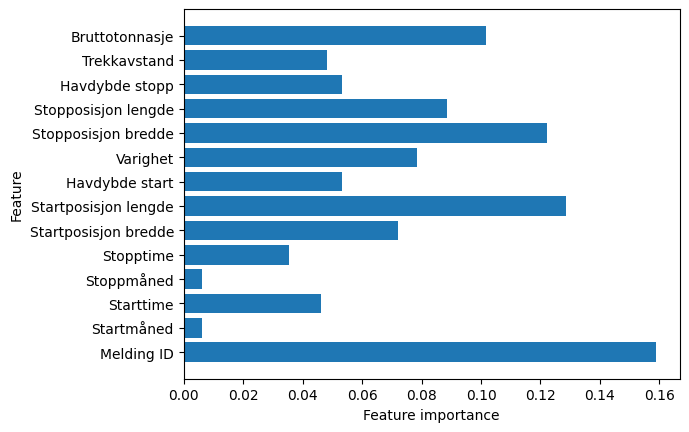

In [38]:
def plot_feature_importances_cancer(model):
    n_features = x.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), x.keys())
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
plot_feature_importances_cancer(clf)

In [39]:
# First we try to scale the features
from sklearn.preprocessing import RobustScaler

num_feat = df[['Melding ID', 'Startmåned', 'Starttime', 'Stoppmåned', 'Stopptime', 'Startposisjon bredde', 'Startposisjon lengde', 'Havdybde start',
        'Varighet', 'Stopposisjon bredde', 'Stopposisjon lengde', 'Havdybde stopp', 'Trekkavstand', 'Bruttotonnasje']]
scaler = RobustScaler()
scaled_features = scaler.fit_transform(num_feat)
scaled_df = pd.DataFrame(scaled_features, columns=num_feat.columns)

In [40]:
# Now let's test with the scaled features

x = scaled_df
y = df[['Hyse', 'Sei', 'Torsk']]

X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=seed)
clf = RandomForestRegressor(n_estimators=100, max_features=15, max_depth=40)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


rmse = np.sqrt(mean_squared_error(y_test, y_pred))
std = y_test.std()
print(type(std), type(rmse))
print("RMSE on test set: ", rmse)
print("Standard deviation of the target variable: ", std)

<class 'pandas.core.series.Series'> <class 'numpy.float64'>
RMSE on test set:  4232.0082217582485
Standard deviation of the target variable:  Art FAO
Hyse     3007.727834
Sei      8235.291056
Torsk    6292.372196
dtype: float64


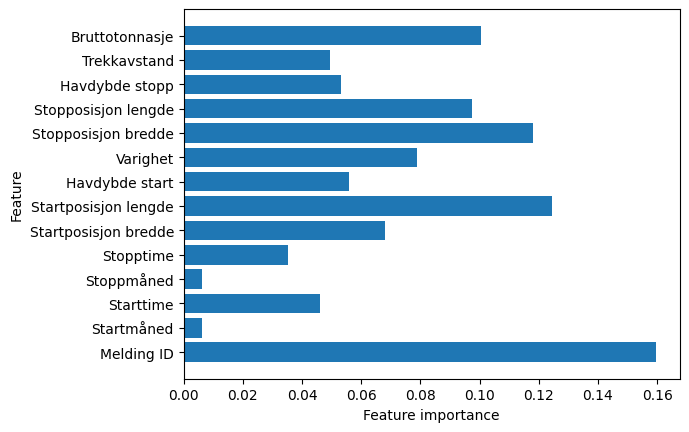

In [41]:
# Test feature importance
def plot_feature_importances_cancer(model):
    n_features = x.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), x.keys())
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
plot_feature_importances_cancer(clf)

In [42]:
from sklearn.preprocessing import OneHotEncoder


w = df[['Melding ID', 'Startmåned', 'Starttime', 'Stoppmåned', 'Stopptime', 'Startposisjon bredde', 'Startposisjon lengde', 'Havdybde start',
        'Varighet', 'Stopposisjon bredde', 'Stopposisjon lengde', 'Havdybde stopp', 'Trekkavstand', 'Bruttotonnasje']]
cat_feat = df[["Redskap FAO", "Hovedart FAO"]]
encoder = OneHotEncoder()
enc_feat= encoder.fit_transform(cat_feat)
enc_df = pd.DataFrame(enc_feat.toarray(), columns=encoder.get_feature_names_out())
s = pd.concat([w, enc_df], axis=1)


In [43]:
# Categorical one-hot encoded + numerical
y = df[['Hyse', 'Sei', 'Torsk']]

X_train, X_test, y_train, y_test = train_test_split(s, y, random_state=seed)
clf = RandomForestRegressor(n_estimators=100, max_features=15, max_depth=40)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


rmse = np.sqrt(mean_squared_error(y_test, y_pred))
std = y_test.std()
print(type(std), type(rmse))
print("RMSE on test set: ", rmse)
print("Standard deviation of the target variable: ", std)

<class 'pandas.core.series.Series'> <class 'numpy.float64'>
RMSE on test set:  3927.1994740593914
Standard deviation of the target variable:  Art FAO
Hyse     3007.727834
Sei      8235.291056
Torsk    6292.372196
dtype: float64


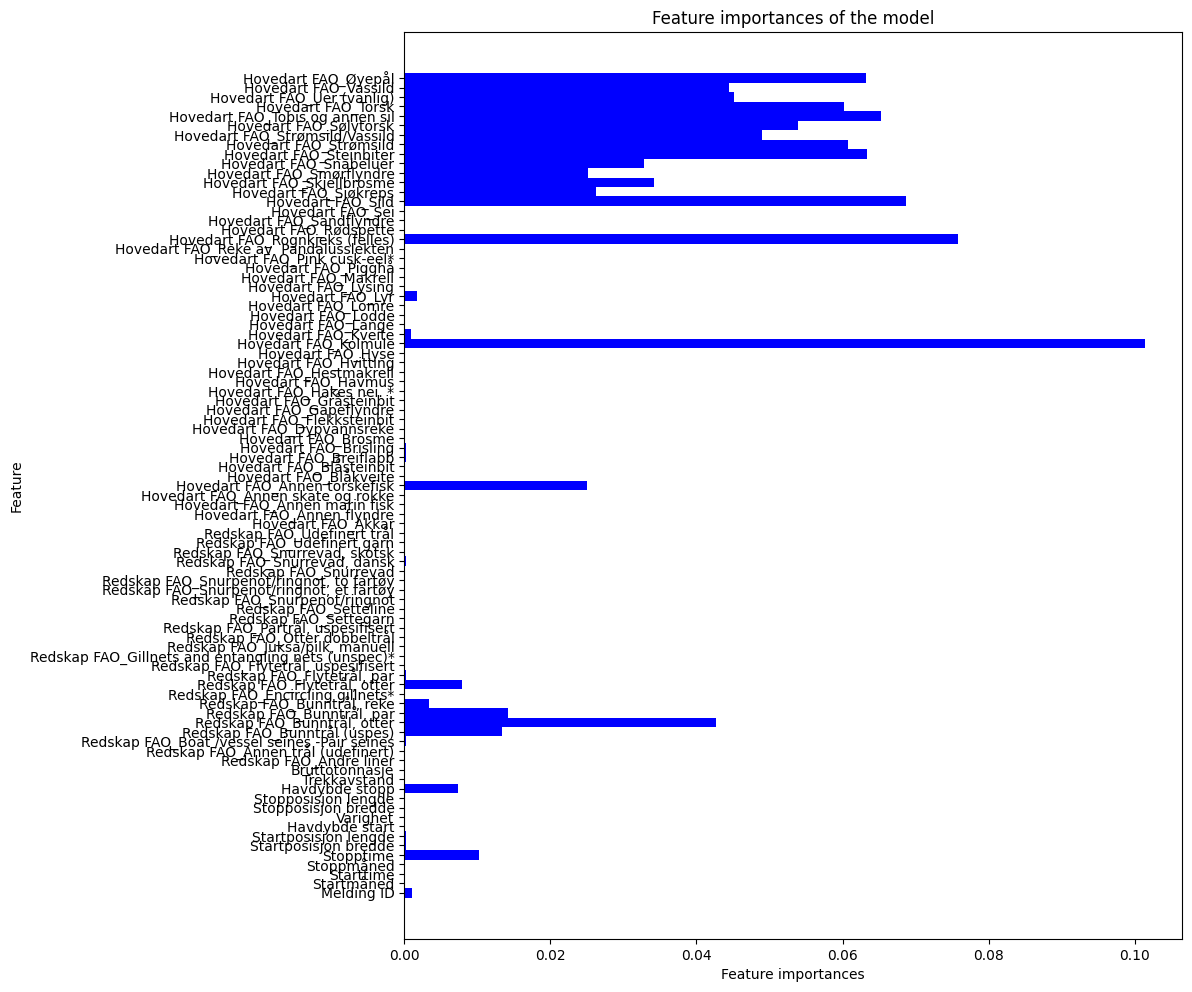

In [49]:
# def plot_feature_importances_cancer(model):
#     n_features = x.shape[1]
#     plt.barh(range(n_features), model.feature_importances_, align='center')
#     plt.yticks(np.arange(n_features), x.keys())
#     plt.xlabel("Feature importance")
#     plt.ylabel("Feature")
# plot_feature_importances_cancer(clf)

# def plot_feature_importances(model):
#     n_features = len(s.columns)
#     feature_indices = s.columns.tolist()
#     feature_importances = model.feature_importances_
#     sorted_idx = np.argsort(feature_importances)[::-1]
#     sorted_feature_importances = feature_importances[sorted_idx]
#     sorted_feature_names = feature_indices + ['{}_{}'.format(feature_indices[i].split(' ')[0], i) for i in sorted_idx if i < len(feature_indices)]

#     # Ensure the number of feature importances matches the number of features
#     sorted_feature_importances = sorted_feature_importances[:n_features]
    
#     # Create a new figure with a bar plot
#     fig = plt.figure(figsize=(12,10))
#     plt.subplot(111)
#     plt.barh(range(n_features), sorted_feature_importances, height=1, color='b', align='center')
#     plt.yticks(np.arange(n_features), sorted_feature_names[:n_features])
#     plt.xlabel("Feature importances")
#     plt.ylabel("Feature")
#     plt.title("Feature importances of the model".format(model.__class__.__name__))
#     plt.tight_layout(pad=1.0)
# plot_feature_importances(clf)

def plot_feature_importances(model):
    n_features = len(s.columns)
    feature_indices = s.columns.tolist()
    feature_importances = model.feature_importances_

    # No sorting of feature importances
    sorted_feature_importances = feature_importances
    sorted_feature_names = feature_indices + ['{}_{}'.format(feature_indices[i].split(' ')[0], i) for i in range(len(feature_indices))]

    # Ensure the number of feature importances matches the number of features
    sorted_feature_importances = sorted_feature_importances[:n_features]
    
    # Create a new figure with a bar plot
    fig = plt.figure(figsize=(12,10))
    plt.subplot(111)
    plt.barh(range(n_features), sorted_feature_importances, height=1, color='b', align='center')
    plt.yticks(np.arange(n_features), sorted_feature_names[:n_features])
    plt.xlabel("Feature importances")
    plt.ylabel("Feature")
    plt.title("Feature importances of the model".format(model.__class__.__name__))
    plt.tight_layout(pad=1)

plot_feature_importances(clf)



In [45]:
q = pd.concat([enc_df, scaled_df], axis=1)

y = df[['Hyse', 'Sei', 'Torsk']]

X_train, X_test, y_train, y_test = train_test_split(q, y, random_state=seed)
clf = RandomForestRegressor(n_estimators=100, max_features=15, max_depth=40)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


rmse = np.sqrt(mean_squared_error(y_test, y_pred))
std = y_test.std()
print(type(std), type(rmse))
print("RMSE on test set: ", rmse)
print("Standard deviation of the target variable: ", std)

<class 'pandas.core.series.Series'> <class 'numpy.float64'>
RMSE on test set:  3923.6745559069336
Standard deviation of the target variable:  Art FAO
Hyse     3007.727834
Sei      8235.291056
Torsk    6292.372196
dtype: float64


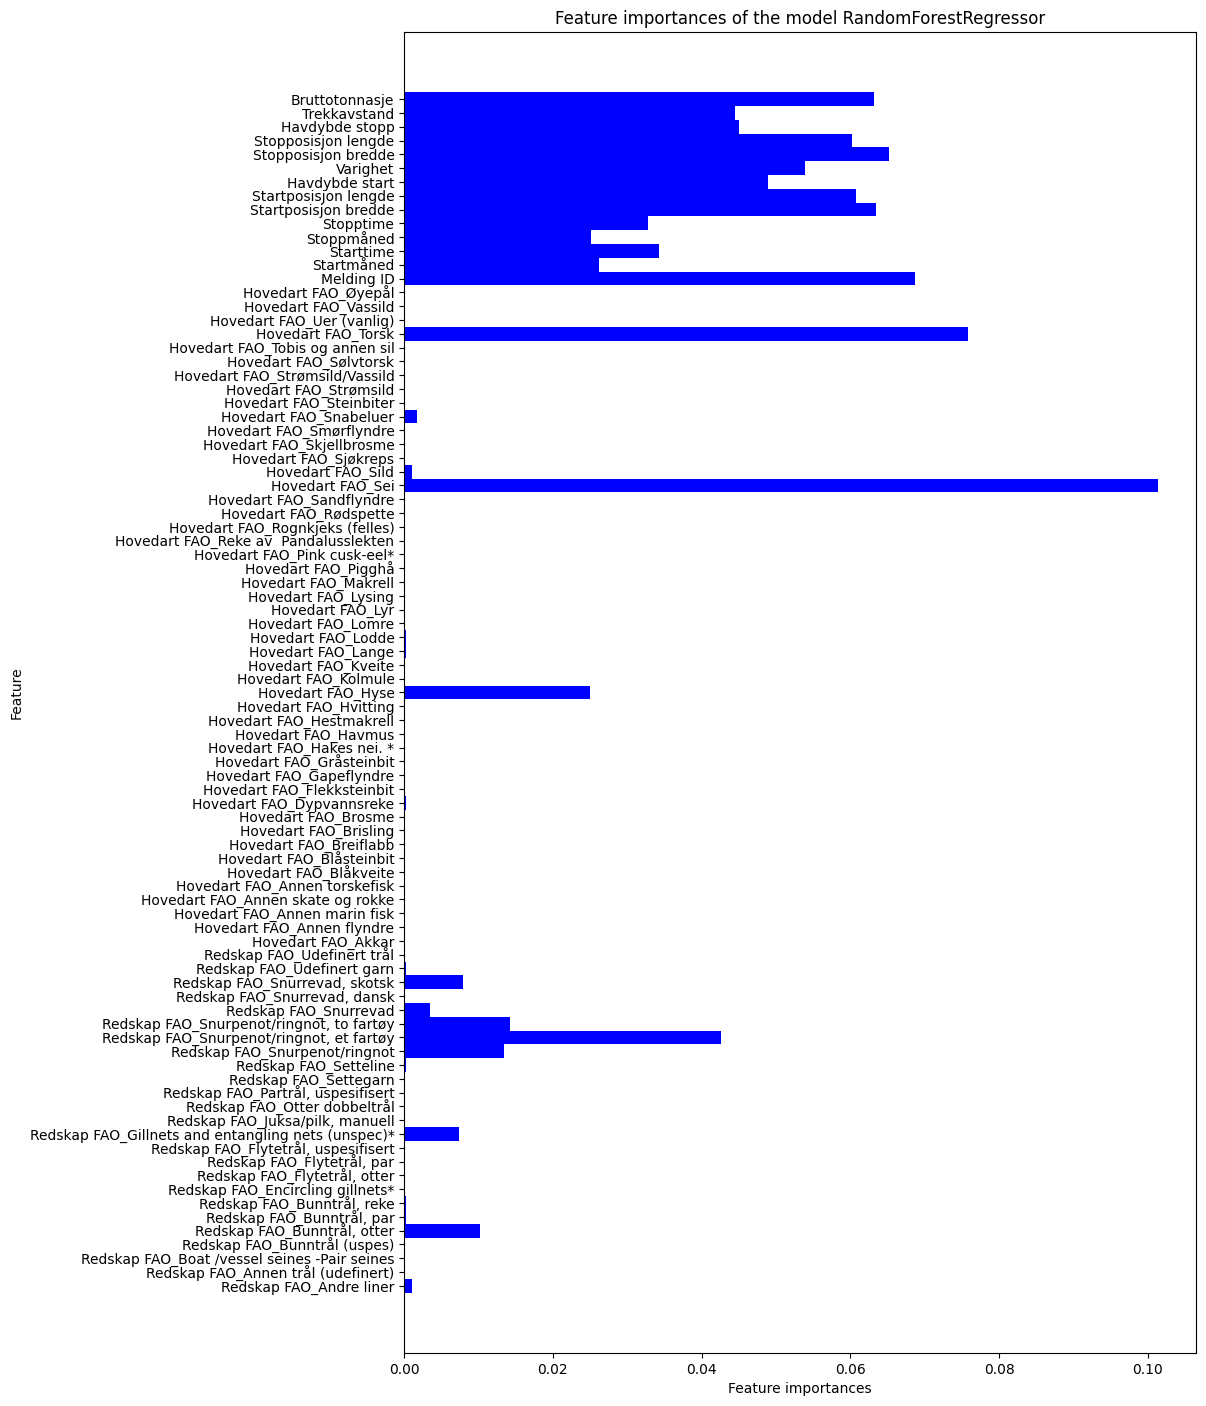

In [58]:
# def plot_feature_importances(model):
#     n_features = len(q.columns)
#     feature_indices = q.columns.tolist()
#     feature_importances = model.feature_importances_
#     sorted_idx = np.argsort(feature_importances)[::-1]
#     sorted_feature_importances = feature_importances[sorted_idx]
#     sorted_feature_names = feature_indices + ['{}_{}'.format(feature_indices[i].split(' ')[0], i) for i in sorted_idx if i < len(feature_indices)]

#     # Ensure the number of feature importances matches the number of features
#     sorted_feature_importances = sorted_feature_importances[:n_features]
    
#     # Create a new figure with a bar plot
#     fig = plt.figure(figsize=(12,10))
#     plt.subplot(111)
#     plt.barh(range(n_features), sorted_feature_importances, height=1, color='b', align='center')
#     plt.yticks(np.arange(n_features), sorted_feature_names[:n_features])
#     plt.xlabel("Feature importances")
#     plt.ylabel("Feature")
#     plt.title("Feature importances of the model".format(model.__class__.__name__))
#     plt.tight_layout(pad=1.0)
# plot_feature_importances(clf)

# Remake this into a reuseable function instead of re-writing it

def plot_feature_importances(model):
    n_features = len(q.columns)
    feature_indices = q.columns.tolist()
    feature_importances = model.feature_importances_

    fig = plt.figure(figsize=(12,14))
    plt.subplot(111)
    plt.barh(range(n_features), feature_importances, height=1, color='b', align='center')
    plt.yticks(np.arange(n_features), feature_indices[:n_features])
    plt.xlabel("Feature importances")
    plt.ylabel("Feature")
    plt.title("Feature importances of the model {}".format(model.__class__.__name__))
    plt.tight_layout(pad=0.5)

plot_feature_importances(clf)